### Importing libraries

In [19]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import preprocessing
from itertools import islice
import seaborn as sns
from scipy.stats import binom
from scipy.stats import norm
import statsmodels.stats.api as sms

In [36]:
import warnings
warnings.filterwarnings('ignore')

### Dataset

In [37]:
data_frame = pd.read_csv("../Data/AdSmartABdata.csv")

In [38]:
data_frame.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [39]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


### cleaning the Data

Below We will clean the 6 variables because our target variable is Experiment variable.

In [87]:
clean_Ad_data = data_frame.drop(['auction_id', 'date', 'hour', 'device_make', 'platform_os', 'browser'], axis=1)

In [88]:
clean_Ad_data = clean_Ad_data[(clean_Ad_data['yes'] != 0) | clean_Ad_data['no'] != 0]
clean_Ad_data['aware'] = 0
clean_Ad_data.loc[clean_Ad_data['yes'] == 1, 'aware'] = 1
clean_Ad_data.loc[clean_Ad_data['yes'] == 0, 'aware'] = 0

clean_Ad_data

,experiment,yes,no,aware
2,exposed,0,1,0
16,exposed,1,0,1
20,exposed,0,1,0
23,control,1,0,1
27,control,0,1,0
...,...,...,...,...
8059,exposed,1,0,1
8063,exposed,1,0,1
8064,control,0,1,0
8069,control,0,1,0


In [89]:
ad_summary = clean_Ad_data.pivot_table(values='aware', index='experiment', aggfunc=np.sum)

ad_summary['total'] = clean_Ad_data.pivot_table(values='aware', index='experiment', aggfunc=lambda x: len(x))
ad_summary['not aware'] = ad_summary['total'] - ad_summary['aware']
ad_summary['rate'] = clean_Ad_data.pivot_table(values='aware', index='experiment')
ad_summary = ad_summary.reindex(['aware', 'not aware', 'total', 'rate'], axis=1)
ad_summary

,aware,not aware,total,rate
experiment,,,,
control,264,322,586,0.450512
exposed,308,349,657,0.468798


###  the above table descibe as difference in conversion rates between the two groups is 1.8%.

from experiment column we will drop users that has not yes or no respond 

In [115]:
drop_mask = data_frame.query('yes==0 and no==0')

In [116]:
data_frame=data_frame.drop(drop_mask.index)

In [117]:
class plots:
    def count_plot(data_frame: pd.DataFrame, column: str) -> None:
        plt.figure(figsize=(9, 7))
        sns.countplot(data=data_frame, x=column)
        plt.title(f'Plot count of {column}', size=20, fontweight='bold')
        plt.show()

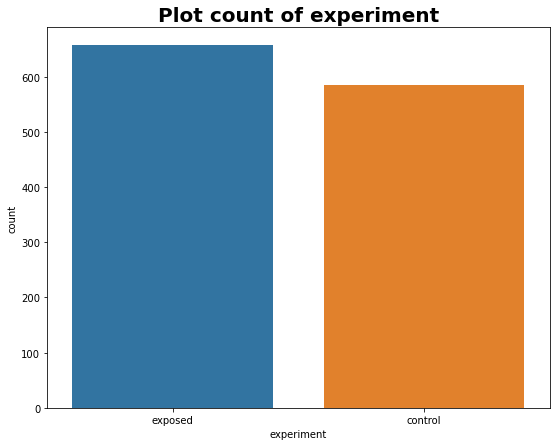

In [118]:
plots.count_plot(data_frame, 'experiment')

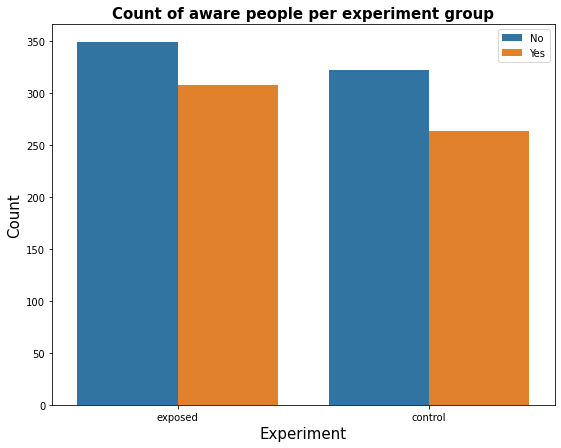

In [119]:
plt.figure(figsize=(9,7))
ax=sns.countplot(x ='experiment', hue='yes', data = clean_Ad_data) 

ax.set_xlabel('Experiment', fontsize=15)
ax.set_ylabel('Count' , fontsize=15)
ax.set_title('Count of aware people per experiment group', fontsize=15, fontweight='bold')
plt.legend( ['No', 'Yes'])

Text(0.5, 1.0, 'Top Browsers used')

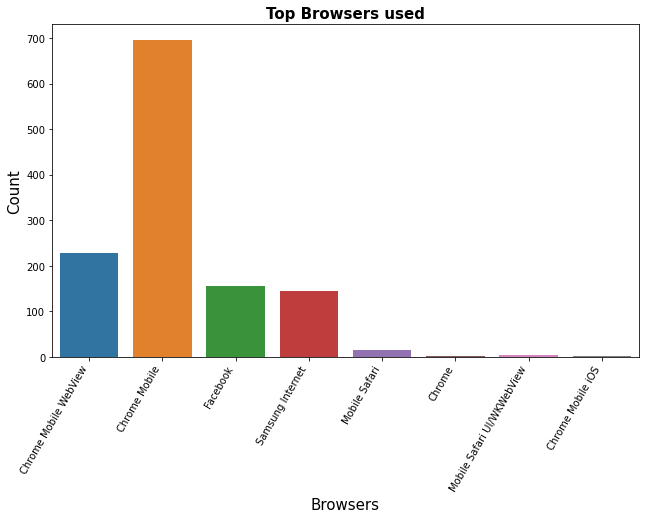

In [120]:
plt.figure(figsize=(9,7))
ax= sns.countplot(x ='browser', data = data_frame) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.tight_layout()
ax.set_xlabel('Browsers', fontsize=15)
ax.set_ylabel('Count' , fontsize=15)
ax.set_title('Top Browsers used', fontsize=15, fontweight='bold')

### the above plot show most used Browser 

Text(0.5, 1.0, 'Distribution of Hour')

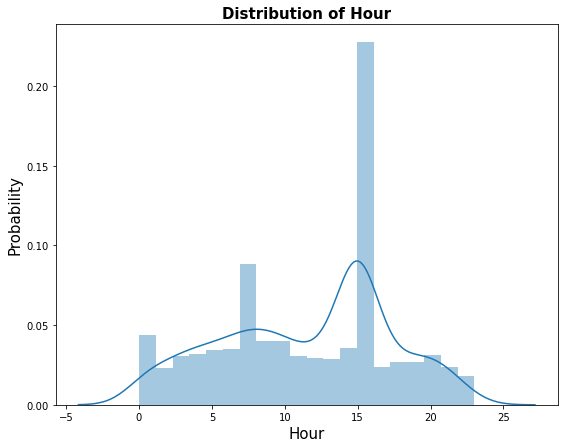

In [136]:
plt.figure(figsize=(9,7))
#top_5_device= data_frame['device_make'].value_counts().nlargest(5)
ax=sns.distplot(data_frame['hour'],bins=20) 
ax.set_xlabel('Hour', fontsize=15)
ax.set_ylabel('Probability' , fontsize=15)
plt.title('Distribution of Hour',fontsize=15,  fontweight='bold')

###  The above plot shows Hours distribution. people use the internet (view the ad) throughout the day.

In [122]:
exposed_yes = data_frame.query('experiment == "exposed"').yes
exposed_count = len(exposed_yes)
exposed_yes_count = exposed_yes.sum(axis=0)

control_yes =  data_frame.query('experiment == "control"').yes
control_count = len(control_yes)
control_yes_count = control_yes.sum(axis=0)
print('Converted Control:',control_yes_count,'    Total Control:',control_count)
print('Converted Exposed:',exposed_yes_count,'    Total Exposed:',exposed_count)

Converted Control: 264     Total Control: 586
Converted Exposed: 308     Total Exposed: 657


### The above out put show the Splited dataframe of the experiment groups.It contains The number of total people in each group.

In [123]:

baseline_rate = control_yes_count / control_count
practical_significance = 0.01 
confidence_level = 0.05 
sensitivity = 0.8 

effect_size = sms.proportion_effectsize(baseline_rate, baseline_rate + practical_significance)
sample_size = sms.NormalIndPower().solve_power(effect_size = effect_size, power = sensitivity, 
                                               alpha = confidence_level, ratio=1)
print("Required sample size: ", round(sample_size), " per group")

baseline_rate = control_yes_count / control_count
practical_significance = 0.01 
confidence_level = 0.05 
sensitivity = 0.8 

effect_size = sms.proportion_effectsize(baseline_rate, baseline_rate + practical_significance)
sample_size = sms.NormalIndPower().solve_power(effect_size = effect_size, power = sensitivity, 
                                               alpha = confidence_level, ratio=1)
print("Required sample size: ", round(sample_size), " per group")

Required sample size:  38932  per group
Required sample size:  38932  per group


### As shown above, I have short required sample size . infact I have only 586 and 657 in each group

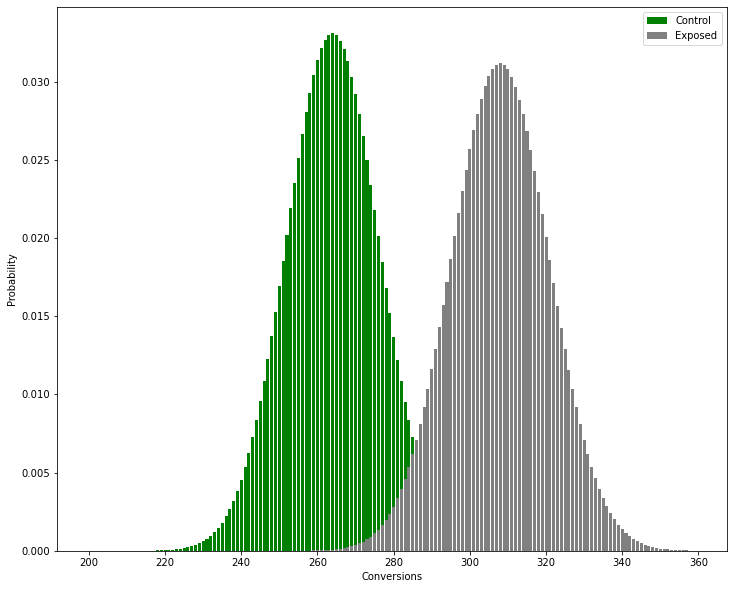

In [124]:
cv_rate_control, cv_rate_exposed = control_yes_count / control_count, exposed_yes_count / exposed_count
range = np.arange(200, 360)
cv_prob_control = binom(control_count, cv_rate_control).pmf(range)
cv_prob_exposed = binom(exposed_count, cv_rate_exposed).pmf(range)
fig, ax = plt.subplots(figsize=(12,10))
plt.bar(range, cv_prob_control, label="Control",color='green')
plt.bar(range, cv_prob_exposed, label="Exposed",color='gray')
plt.legend()
plt.xlabel("Conversions"); plt.ylabel("Probability");


### Next we will Calculate standard deviations for each experiment group. This will help us change our binomial distribution to normal by using the central limit theorem(CLT). We can then calculate z-scores.

In [125]:
std_dev_control = np.sqrt(cv_rate_control * (1 - cv_rate_control) / control_count)
std_dev_exposed = np.sqrt(cv_rate_exposed * (1 - cv_rate_exposed) / exposed_count)

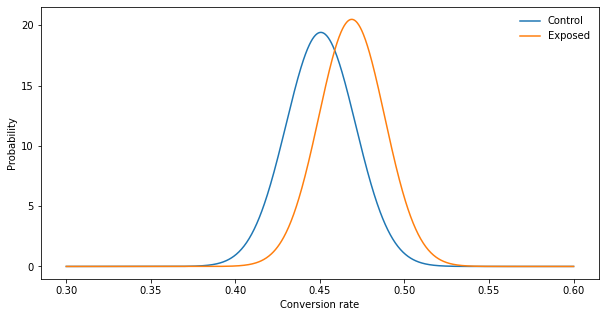

In [134]:
conversion_rate = np.linspace(0.3, 0.6, 1000)
prob_a = norm(cv_rate_control, std_dev_control).pdf(conversion_rate)
prob_b = norm(cv_rate_exposed, std_dev_exposed).pdf(conversion_rate)
plt.figure(figsize=(10,5))

plt.plot(conversion_rate, prob_a, label="Control")

plt.plot(conversion_rate, prob_b, label="Exposed")

plt.legend(frameon=False)
plt.xlabel("Conversion rate"); plt.ylabel("Probability");

### Next we will Compute Z-Score

zscore is 0.646, with p-value 0.259


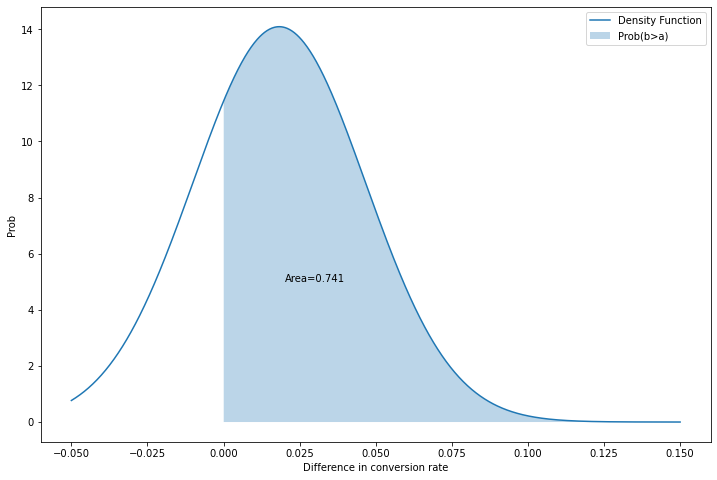

In [127]:
z_score = (cv_rate_exposed - cv_rate_control) / np.sqrt(std_dev_control**2 + std_dev_exposed**2)
p = norm(cv_rate_exposed - cv_rate_control, np.sqrt(std_dev_control**2 + std_dev_exposed**2))

x = np.linspace(-0.05, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.figure(figsize=(12,8))
plt.plot(x, y, label="Density Function")
plt.fill_between(x, 0, y, where=x>0, label="Prob(b>a)", alpha=0.3)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate"); plt.ylabel("Prob");

print(f"zscore is {z_score:0.3f}, with p-value {norm().sf(z_score):0.3f}")

###  We get 0.741 confidence interval.so What this telling is 74.1% of time the exposed group has same awareness with the control group and 25.1% of a time the exposed group has different awareness with the control group. From our A/B test we can see that even if we saw a rise in conversion rate in the exposed group for this particular experiment, it may be a result of random chance.we cannot conclude that the experiment group has more awareness.so our p-value is 0.259 which is less than 0.05.

## we will accept the null hypothesis